# Introduction
This note book applies time series analysis to random number sequence. The idea is to see if ML model can be effectively used to predict yet-to-come random draw!

In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.3.0'

## UDFs

Functions for various steps in the model:

In [50]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """
    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:
        for series_num in series:
            plt.plot(time[start:end], series_num[start:end], format)

    else:
        plt.plot(time[start:end], series[start:end], format)

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()


# The following function, takes a series along with other parameters and creates TF dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    # dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset


def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

Set the paramters for the data pre-processing. These are used in TensorFlow windowing steps.

In [54]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

Generate sequence of random integers and create training and validation sets:

In [55]:
L = 10000
time = np.arange(L)
# Define the split time
split_time = 9500

random.seed(7)
series = np.array(random.choices(range(10), k=L))

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [56]:
dataset = windowed_dataset(x_train, window_size, batch_size,shuffle_buffer_size)

In [57]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


# Naive model
Generate random numbers as prediction value and evaluate the performance:

In [58]:
# get the length of the validation seq and generate seq of random integers of the same length using different seed
L = len(x_valid)
print(L)
random.seed(10)
yhat_random = np.array(random.choices(range(10), k=L))

500


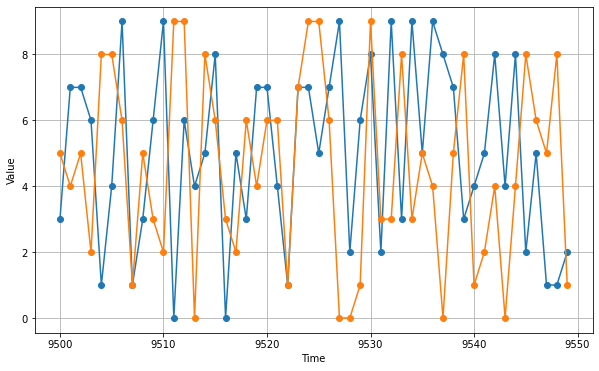

In [59]:
# Overlay the results with the validation set
plot_series(time_valid, (x_valid, yhat_random),format="-o", start=0, end=50)

In [60]:
# count how many time random prediction matches the underlying sequence:
print(f'Count of the matching between two sequences: {np.sum(yhat_random == x_valid)}')
print(f'Fraction of the matching between two sequences: {round(np.sum(yhat_random == x_valid) / len(x_valid),3)}')
# Compute the metrics
print(f'MSE of the model: {tf.keras.metrics.mean_squared_error(x_valid, yhat_random).numpy()}')
print(f'MAE of the model: {tf.keras.metrics.mean_absolute_error(x_valid, yhat_random).numpy()}')

Count of the matching between two sequences: 40
Fraction of the matching between two sequences: 0.08
MSE of the model: 16
MAE of the model: 3


Another form of Naive model is using only one random for forecasting, e.g. yhat=5 for all future time stamps.

In [61]:
L = len(x_valid)
random.seed(1)
yhat_random = np.array([random.randint(0,9)]*L)
print(f'Count of the matching between two sequences: {np.sum(yhat_random == x_valid)}')
print(f'Fraction of the matching between two sequences: {round(np.sum(yhat_random == x_valid) / len(x_valid),3)}')
print(f'MSE of the model: {tf.keras.metrics.mean_squared_error(x_valid, yhat_random).numpy()}')
print(f'MAE of the model: {tf.keras.metrics.mean_absolute_error(x_valid, yhat_random).numpy()}')

Count of the matching between two sequences: 45
Fraction of the matching between two sequences: 0.09
MSE of the model: 14
MAE of the model: 3


## Build and compile the model

Next, you will build the single layer neural network. This will just be a one-unit [Dense](https://keras.io/api/layers/core_layers/dense/) layer as shown below.

In [62]:
# Build the single layer neural network
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# Print the initial layer weights
# print("Layer weights: \n {} \n".format(l0.get_weights()))

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [91]:
# Set the training parameters
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=50, verbose=1)

Epoch 1/50
297/297 [==============================] - 2s 5ms/step - loss: 8.6194
Epoch 2/50
297/297 [==============================] - 1s 5ms/step - loss: 8.6163
Epoch 3/50
297/297 [==============================] - 2s 5ms/step - loss: 8.6138
Epoch 4/50
297/297 [==============================] - 1s 5ms/step - loss: 8.6115
Epoch 5/50
297/297 [==============================] - 2s 5ms/step - loss: 8.6094
Epoch 6/50
297/297 [==============================] - 2s 5ms/step - loss: 8.6075
Epoch 7/50
297/297 [==============================] - 2s 6ms/step - loss: 8.6058
Epoch 8/50
297/297 [==============================] - 2s 7ms/step - loss: 8.6043
Epoch 9/50
102/297 [=========>....................] - ETA: 1s - loss: 8.6332

KeyboardInterrupt: 

In [48]:
# Print the layer weights
# print("Layer weights {}".format(l0.get_weights()))

In [72]:
# Sample model prediction
n = 100
print(f'model prediction: {model.predict(series[n:n+window_size][np.newaxis])}')
print(f'actual value: {series[n+window_size]}')

model prediction: [[4.22237]]
actual value: 3


519
500
500


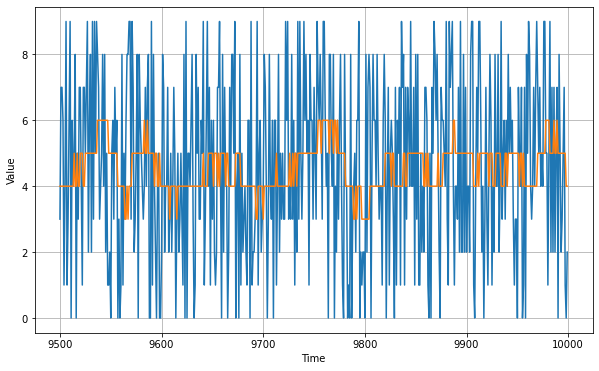

In [87]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# round each prediction to the closest integer:
results = [int(round(x)) for x in results]
print(len(forecast_series))
print(len(results))
print(len(time_valid))
# Compute the metrics
# print(f'Count of the matching between two sequences: {np.sum(results == x_valid)}')
# print(f'Fraction of the matching between two sequences: {round(np.sum(results == x_valid) / len(x_valid),3)}')
# print(f'MSE of the model: {tf.keras.metrics.mean_squared_error(x_valid, results).numpy()}')
# print(f'MAE of the model: {tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()}')

# Plot the results
plot_series(time_valid, (x_valid, results))
# plot_series(time[window_size:-1], (series[window_size:-1], results))


### Ignore the rest of the notebook -- Mostly experiments or from old verisons. Check the previous versions!

In [136]:
# Initialize a list
forecast = []

# Use the model to predict data points per window size
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Slice the points that are aligned with the validation set
forecast = forecast[split_time - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

length of the forecast list: 500
shape of the validation set: (500,)


In [137]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
results = [int(round(x)) for x in results]

shape after converting to numpy array: (500, 1, 1)
shape after squeezing: (500,)
